<a href="https://colab.research.google.com/github/theAkhileshRai/ComputerVision/blob/master/DesnseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l

     |████████████████████████████████| 711.0MB 25kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Cloning https://github.com/d2l-ai/d2l-en to /tmp/pip-req-build-tmtomwky
  Running command git clone -q https://github.com/d2l-ai/d2l-en /tmp/pip-req-build-tmtomwky
  Created wheel for d2l: filename=d2l-0.11.4-cp36-none-any.whl size=31756 sha256=abcf8ddb3bdceb4a8d3597d9c61e227a22322e235d158c6bddbdedbbe035e431
  Stored in directory: /tmp/pip-ephem-wheel-cache-xegwjnt2/wheels/82/6f/b8/8422c7ed664272685e3d139b127f89df39d934704a14b2156c
Successfully built d2l
Requirement already up-to-date: mxnet-cu101mkl in /usr/local/lib/python3.6/dist-packages (1.6.0)
  Cloning https://github.com/d2l-ai/d2l-en to /tmp/pip-req-build-3hh3wrdk
  Running command git clone -q https://github.com/d2l-ai/d2l-en /tmp/pip-req-build-3hh3wrdk
  Created wheel for d2l: filename=d2l-0.11.4-cp36-none-any.whl size=31756 sha256=d918aaef67c

In [0]:
#DenseNet
import d2l
from mxnet import np, npx
from mxnet.gluon import nn
npx.set_np()

def conv_block(num_channels):
    blk = nn.Sequential()
    blk.add(nn.BatchNorm(),
            nn.Activation('relu'),
            nn.Conv2D(num_channels, kernel_size=3, padding=1))
    return blk

In [0]:
class DenseBlock(nn.Block):
    def __init__(self, num_convs, num_channels, **kwargs):
        super(DenseBlock, self).__init__(**kwargs)
        self.net = nn.Sequential()
        for _ in range(num_convs):
            self.net.add(conv_block(num_channels))

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = np.concatenate((X, Y), axis=1)
        return X

In [5]:
blk = DenseBlock(2, 10)
blk.initialize()
X = np.random.uniform(size=(4, 3, 8, 8))
Y = blk(X)
Y.shape

(4, 23, 8, 8)

In [0]:
def transition_block(num_channels):
    blk = nn.Sequential()
    blk.add(nn.BatchNorm(), nn.Activation('relu'),
            nn.Conv2D(num_channels, kernel_size=1),
            nn.AvgPool2D(pool_size=2, strides=2))
    return blk

In [0]:
net = nn.Sequential()
net.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3),
        nn.BatchNorm(), nn.Activation('relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))

In [0]:
#DenseNet Model
# Num_channels: the current number of channels
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]

for i, num_convs in enumerate(num_convs_in_dense_blocks):
    net.add(DenseBlock(num_convs, growth_rate))
    # This is the number of output channels in the previous dense block
    num_channels += num_convs * growth_rate
    # A transition layer that haves the number of channels is added between
    # the dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        num_channels //= 2
        net.add(transition_block(num_channels))

In [0]:
net.add(nn.BatchNorm(),
        nn.Activation('relu'),
        nn.GlobalAvgPool2D(),
        nn.Dense(10))

loss 0.144, train acc 0.947, test acc 0.873
1388.4 examples/sec on gpu(0)


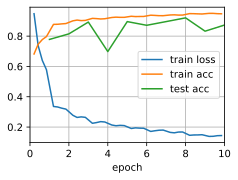

In [10]:
lr, num_epochs, batch_size = 0.09, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)